In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Council-specific report run

Script will produce frequency and close-time plots for the council, request types, and date ranges specified in run variables below. 

*Modified version of gennaAnalysis.ipynb*

In [3]:
# Set run variables
NCNAMEVAR = 'VOICES OF 90037'    # Council to compile data for
STARTDATEVAR = '2019-05-01'      # Date from which to run query (from STARTDATE to present)
REQUESTVAR = ['Bulky Items','Illegal Dumping Pickup'] # Which request types to generate reports for

In [4]:
dfb = pd.read_table('~/Downloads/311data2019.tsv',sep='\t')

In [5]:
# For this version of notebook subset aggressively to only necessary NC
# Run goes much faster due to fewer variable recasts, but does not return
# summary stats for full dataset (only council of interest)
dfb = dfb[dfb.NCName == NCNAMEVAR]

In [6]:
dfb.head()

SRNumber             CreatedDate             UpdatedDate ActionTaken  \
139  1-1262713881  01/01/2019 09:31:43 AM  01/01/2019 11:00:22 AM  SR Created   
163  1-1262717721  01/01/2019 09:55:22 AM  01/02/2019 10:41:15 AM  SR Created   
168  1-1262721431  01/01/2019 09:56:39 AM  01/02/2019 08:33:05 AM  SR Created   
171  1-1262721521  01/01/2019 09:58:03 AM  01/02/2019 08:50:25 AM  SR Created   
553  1-1262775641  01/01/2019 02:31:38 PM  01/02/2019 11:52:21 AM  SR Created   

    Owner                 RequestType  Status RequestSource  \
139   BOS         Dead Animal Removal  Closed          Call   
163   BOS                 Bulky Items  Closed          Call   
168   BOS                 Bulky Items  Closed          Call   
171   BOS  Metal/Household Appliances  Closed          Call   
553   BOS                 Bulky Items  Closed          Call   

    CreatedByUserOrganization MobileOS  ...                         Location  \
139                       BOS      NaN  ...  (33.9960834641, -118.299676526)   
163                       BOS      NaN  ...  (34.0011645689, -118.287983936)   
168                       BOS      NaN  ...  (34.0011645689, -118.287983936)   
171                       BOS      NaN  ...  (34.0011645689, -118.287983936)   
553                       BOS      NaN  ...  (33.9939093207, -118.300108437)   

    TBMPage TBMColumn TBMRow                    APC   CD             CDMember  \
139   673.0         J    4.0  South Los Angeles APC  9.0  Curren D. Price Jr.   
163   674.0         B    4.0  South Los Angeles APC  9.0  Curren D. Price Jr.   
168   674.0         B    4.0  South Los Angeles APC  9.0  Curren D. Price Jr.   
171   674.0         B    4.0  South Los Angeles APC  9.0  Curren D. Price Jr.   
553   673.0         J    5.0  South Los Angeles APC  9.0  Curren D. Price Jr.   

        NC           NCName PolicePrecinct  
139  109.0  VOICES OF 90037    77TH STREET  
163  109.0  VOICES OF 90037    77TH STREET  
168  109.0  VOICES OF 90037    77TH STREET  
171  109.0  VOICES OF 90037    77TH STREET  
553  109.0  VOICES OF 90037    77TH STREET  

[5 rows x 34 columns]

In [7]:
dfb['CreatedDate'] = pd.to_datetime(dfb['CreatedDate'])
dfb['ClosedDate'] = pd.to_datetime(dfb['ClosedDate'])
dfb['ServiceDate'] = pd.to_datetime(dfb['ServiceDate'])

Compute Service time (two ways to do this, not sure which is correct)

Note: *`closed_created` used in this script*

In [8]:
dfb['closed_created'] = dfb.ClosedDate-dfb.CreatedDate
dfb['service_created'] = dfb.ServiceDate-dfb.CreatedDate

In [9]:
dfb.closed_created.describe()

count                      16563
mean      6 days 05:37:53.490611
std      15 days 09:16:30.859878
min            -1 days +05:57:57
25%       0 days 15:10:02.500000
50%              1 days 07:53:33
75%       5 days 17:23:44.500000
max            237 days 22:19:56
Name: closed_created, dtype: object

NB: negative values are probably errors

In [10]:
dfb.closed_created.isna().sum()

531

In [11]:
dfb.shape

(17094, 36)

In [12]:
# drop NA and consider in terms of days
dfb = dfb[~dfb.closed_created.isna()]

#df = dfb.closed_created.dropna().astype('timedelta64[D]')
#df = df[df.between(0,365)]

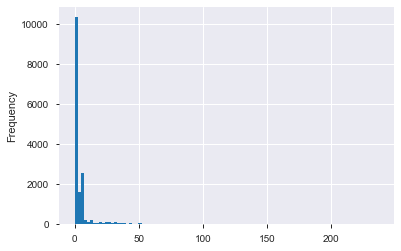

In [13]:
_ = dfb[dfb.closed_created.astype('timedelta64[D]').between(0,365)].closed_created.astype('timedelta64[D]').plot.hist(bins=100)

In [14]:
# Establish number of days between request created and closed
dfb['closed_createdD'] = dfb.closed_created / pd.Timedelta(days=1)
dfb = dfb[dfb.CreatedDate > '2019-05-01']

In [15]:
# Takes all intervals open at least one hour with status 'closed',
# council name of interest, created after specified date
dfbD = dfb[(dfb.closed_createdD>(1.0/24.0)) & (dfb.Status=='Closed') & (dfb.NCName == NCNAMEVAR) & (dfb.CreatedDate > '2019-05-01')][['closed_createdD','RequestType']]


In [16]:
dfbD.closed_createdD.min()

0.04234953703703704

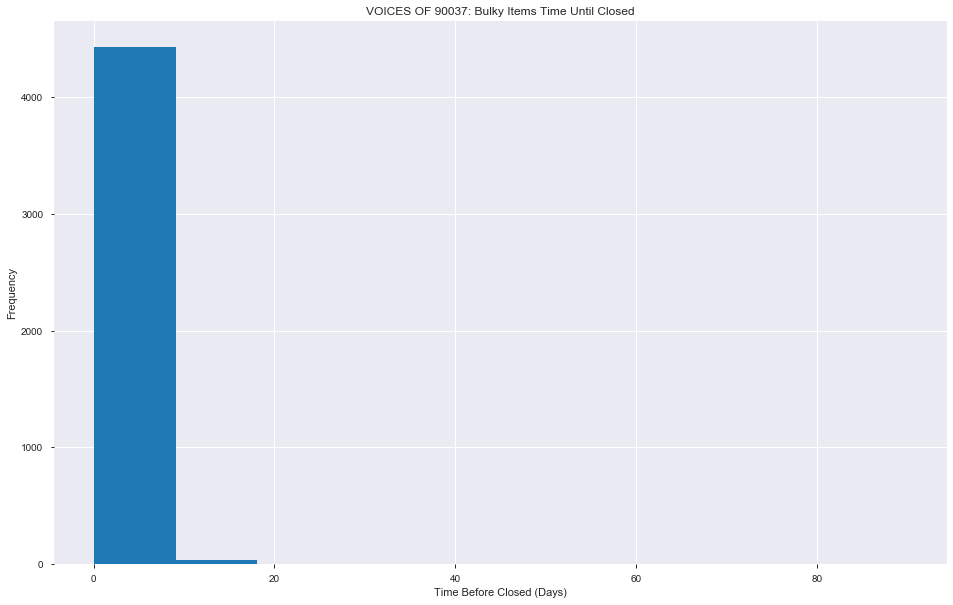

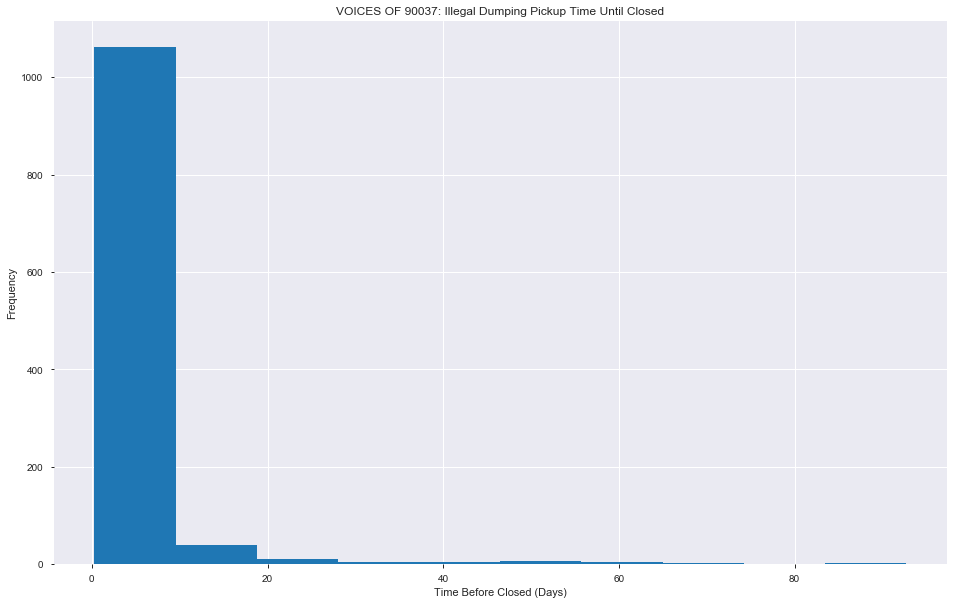

In [17]:
# Create plots of request frequency

for i in REQUESTVAR:
  plt.figure(figsize=(16,10))
  ax = dfbD[(dfbD.RequestType==i)].closed_createdD.plot.hist(bins=10)
  ax.set_xlabel('Time Before Closed (Days)')
  ax.set_title('%s: %s Time Until Closed' % (NCNAMEVAR,i))

## Plots of request close time by request type

In [19]:
# Aggregate summary measures for construction of 
# plots of close-time by request type
dfbDavg = dfbD.groupby(['RequestType']).agg(['mean', 'std', 'min', 'max','count']).reset_index().sort_values(by=['RequestType'])

In [20]:
dfbDavg

RequestType closed_createdD                       \
                                          mean        std       min   
0                  Bulky Items        3.135347   3.569736  0.080405   
1          Dead Animal Removal        0.469638   0.412658  0.042350   
2             Electronic Waste        2.812861   2.381717  0.385718   
3                     Feedback        4.204074        NaN  4.204074   
4             Graffiti Removal       17.087418  16.308270  0.047674   
5          Homeless Encampment       27.725448  31.908272  0.486215   
6       Illegal Dumping Pickup        4.924418   8.394809  0.295451   
7   Metal/Household Appliances        2.894838   2.394348  0.373067   
8   Multiple Streetlight Issue       32.876244  46.956353  0.557894   
9                        Other        1.052011   0.990618  0.074803   
10    Single Streetlight Issue       12.508002  18.410725  0.086528   

                      
           max count  
0    89.874282  4483  
1     2.107188   222  
2    10.352512   280  
3     4.204074     1  
4    91.159005  1246  
5   156.205764   238  
6    92.682130  1138  
7    13.942546   554  
8   183.005012    53  
9     5.154410    42  
10   76.424664    51

In [19]:
# Generate color palate for plotting
dfbDavg['colorvals'] = sns.color_palette('colorblind',11)

In [20]:
dfbDavg

RequestType closed_createdD                       \
                                          mean        std       min   
0                  Bulky Items        3.135347   3.569736  0.080405   
1          Dead Animal Removal        0.469638   0.412658  0.042350   
2             Electronic Waste        2.812861   2.381717  0.385718   
3                     Feedback        4.204074        NaN  4.204074   
4             Graffiti Removal       17.087418  16.308270  0.047674   
5          Homeless Encampment       27.725448  31.908272  0.486215   
6       Illegal Dumping Pickup        4.924418   8.394809  0.295451   
7   Metal/Household Appliances        2.894838   2.394348  0.373067   
8   Multiple Streetlight Issue       32.876244  46.956353  0.557894   
9                        Other        1.052011   0.990618  0.074803   
10    Single Streetlight Issue       12.508002  18.410725  0.086528   

                                                        colorvals  
           max                                                     
0    89.874282  (0.00392156862745098, 0.45098039215686275, 0.6...  
1     2.107188  (0.8705882352941177, 0.5607843137254902, 0.019...  
2    10.352512  (0.00784313725490196, 0.6196078431372549, 0.45...  
3     4.204074      (0.8352941176470589, 0.3686274509803922, 0.0)  
4    91.159005     (0.8, 0.47058823529411764, 0.7372549019607844)  
5   156.205764  (0.792156862745098, 0.5686274509803921, 0.3803...  
6    92.682130  (0.984313725490196, 0.6862745098039216, 0.8941...  
7    13.942546  (0.5803921568627451, 0.5803921568627451, 0.580...  
8   183.005012      (0.9254901960784314, 0.8823529411764706, 0.2)  
9     5.154410  (0.33725490196078434, 0.7058823529411765, 0.91...  
10   76.424664  (0.00392156862745098, 0.45098039215686275, 0.6...

In [21]:
dfbDavg = dfbDavg.sort_values(by=[('closed_createdD','mean')],ascending=False)

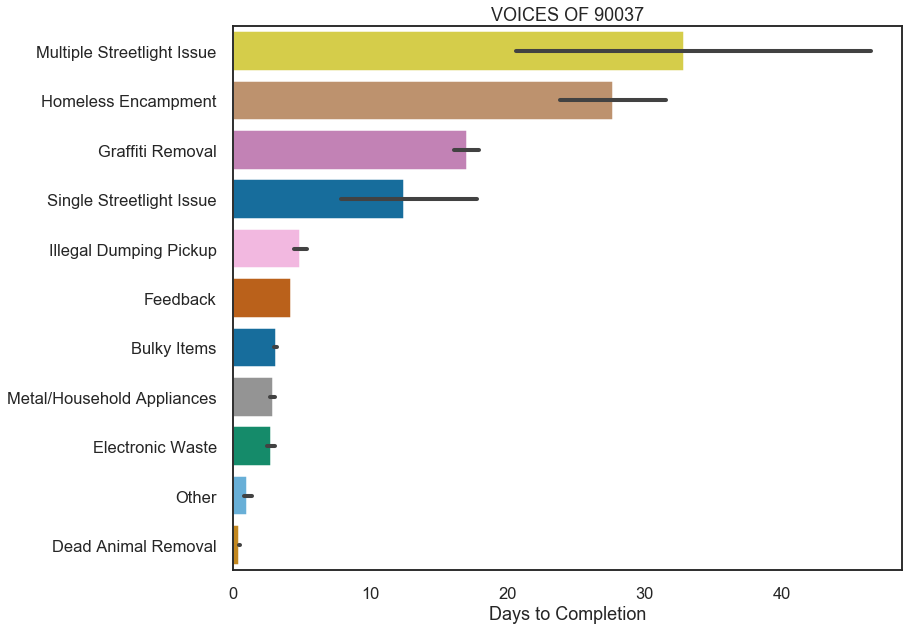

In [22]:
# Plot close-time plot
plt.figure(figsize=(12,10))
sns.set_style("white")
sns.set_context("talk")
ax = sns.barplot(y='RequestType',x='closed_createdD',data=dfbD, order=dfbDavg.RequestType, 
                 palette = list(dfbDavg.colorvals))
#ax = sns.barplot(y="RequestType", x=('closed_createdD','mean'), ci=('closed_createdD','std'), data=dfbDavg)
_ = ax.set(xlabel='Days to Completion',title=NCNAMEVAR,ylabel='')

## Requests for a particular NC by request type

### Frequency of requests over time

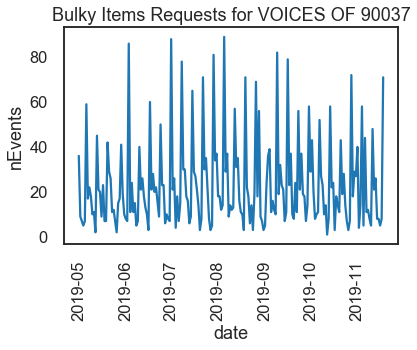

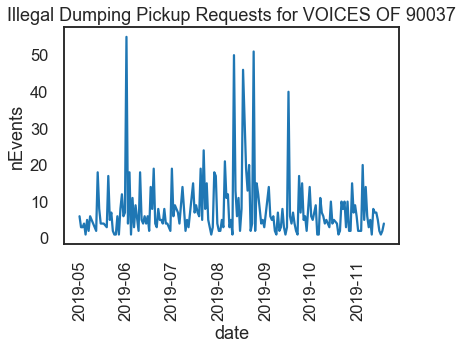

In [23]:
# time/frequency plots of request types

for i in REQUESTVAR:
  plt.figure()
  DTLA_Num = dfb.NC[dfb.NCName==NCNAMEVAR].unique()[0]
  nEvents = dfb[(dfb.NC==DTLA_Num) & (dfb.RequestType==i) & (dfb.Status=='Closed')].CreatedDate.astype('datetime64[D]').value_counts()
  df_events = pd.DataFrame(nEvents).reset_index()
  df_events.columns = ['date','nEvents']
  ax = sns.lineplot(x='date',y='nEvents',data=df_events)
  ax.set(title='%s Requests for %s' % (i,NCNAMEVAR))
  #ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
  plt.setp(ax.get_xticklabels(), rotation=90)  

### Cumulative frequency plots

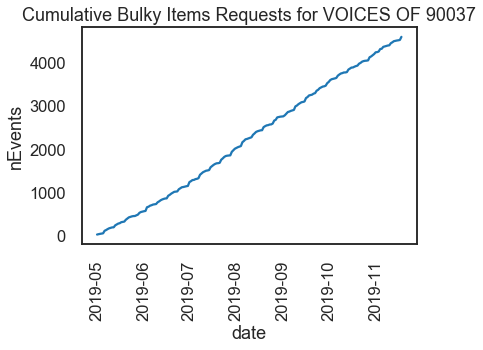

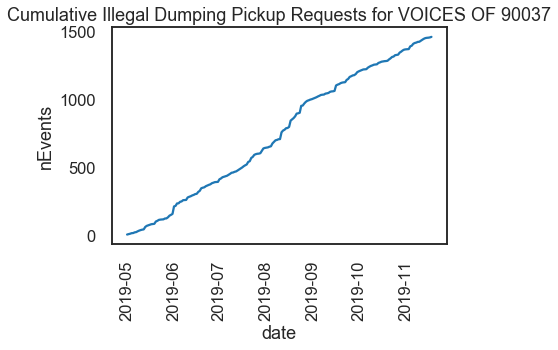

In [24]:
# Cumulative plots for request frequency
for i in REQUESTVAR:
  plt.figure()
  nEvents = dfb[(dfb.NCName==NCNAMEVAR) & (dfb.RequestType==i) & (dfb.Status=='Closed')].CreatedDate.astype('datetime64[D]').value_counts()
  df_events = pd.DataFrame(nEvents).reset_index()
  df_events.columns = ['date','nEvents']
  df_events = df_events.sort_values('date')
  ax = sns.lineplot(x=df_events.date,y=df_events.nEvents.cumsum())
  ax.set(title='Cumulative %s Requests for %s' % (i,NCNAMEVAR))
  plt.setp(ax.get_xticklabels(), rotation=90)

### Request frequency over time with all request types

In [25]:
df52 = dfb[(dfb.NCName==NCNAMEVAR) & (dfb.Status=='Closed')]
df52['CRweek'] = df52.CreatedDate.dt.week
df52['CRmonth'] = df52.CreatedDate.dt.month

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
df52_week = pd.DataFrame(df52.groupby(['RequestType','CRweek']).SRNumber.count()).reset_index()
df52_month = pd.DataFrame(df52.groupby(['RequestType','CRmonth']).SRNumber.count()).reset_index()

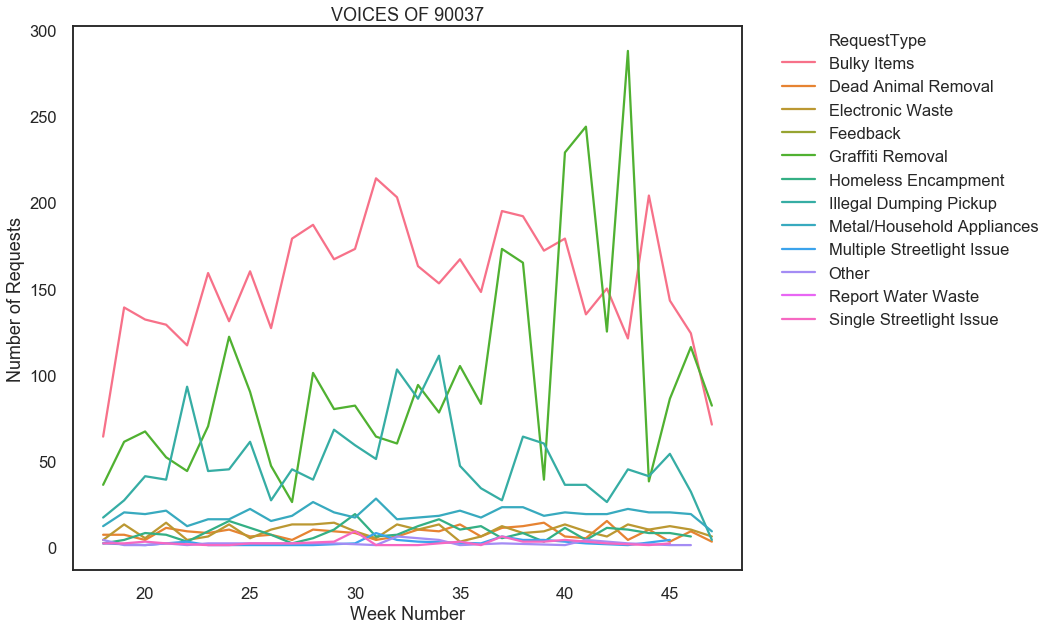

In [27]:
plt.figure(figsize=(12,10))
sns.set_style("white")
sns.set_context("talk")
ax = sns.lineplot(x='CRweek',y='SRNumber',hue='RequestType',data=df52_week)
ax.set(xlabel='Week Number',ylabel='Number of Requests',title=NCNAMEVAR)
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

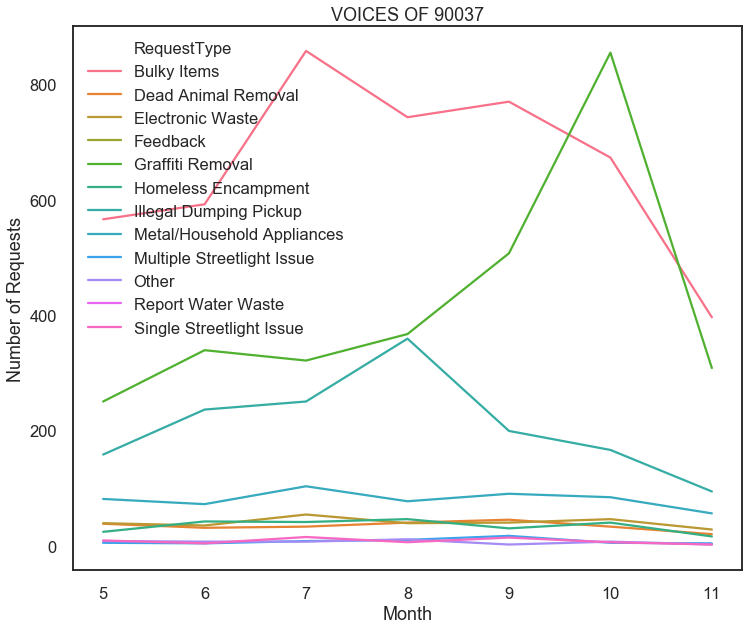

In [28]:
# Same figure but grouped by month instead of week
plt.figure(figsize=(12,10))
sns.set_style("white")
sns.set_context("talk")
ax = sns.lineplot(x='CRmonth',y='SRNumber',hue='RequestType',data=df52_month)
_ = ax.set(xlabel='Month',ylabel='Number of Requests', title=NCNAMEVAR)

In [29]:
def requests_over_time(dfb,NCName):
    '''Function takes council name and returns plot of request frequency'''
    df52 = dfb[(dfb.NCName==NCName) & (dfb.Status=='Closed')]
    df52['CRmonth'] = df52.CreatedDate.dt.month
    df52_month = pd.DataFrame(df52.groupby(['RequestType','CRmonth']).SRNumber.count()).reset_index()
    plt.figure(figsize=(12,10))
    sns.set_style("white")
    sns.set_context("talk")
    ax = sns.lineplot(x='CRmonth',y='SRNumber',hue='RequestType',data=df52_month)
    ax.set(xlabel='Month',ylabel='Number of Requests', title='NC ' + str(NCName),ylim=(0,1500))
    _ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


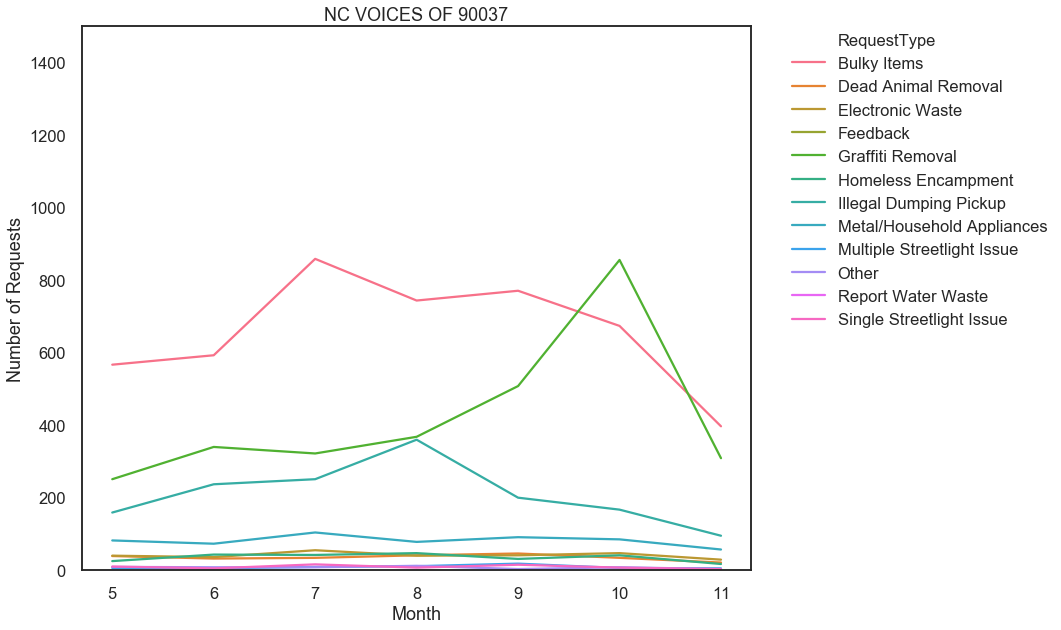

In [30]:
requests_over_time(dfb,NCNAMEVAR)

In [29]:
dfb[dfb.RequestType == 'Bulky Items'].Address.value_counts().to_csv('~/code/addressBulkyCounts.csv')
dfb[dfb.RequestType == 'Illegal Dumping Pickup'].Address.value_counts().to_csv('~/code/addressDumpCounts.csv')


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [32]:
dfb[dfb.RequestType == 'Bulky Items'].to_csv('~/code/90037bulkyFile.csv')
dfb[dfb.RequestType == 'Illegal Dumping Pickup'].to_csv('~/code/90037dumpFile.csv')

In [26]:
dfb

SRNumber         CreatedDate             UpdatedDate ActionTaken  \
386231   1-1343197131 2019-05-01 08:08:27  05/01/2019 02:47:16 PM  SR Created   
386286   1-1343213951 2019-05-01 08:23:27  05/07/2019 11:08:19 AM  SR Created   
386323   1-1343220881 2019-05-01 08:32:20  05/07/2019 01:22:33 PM  SR Created   
386325   1-1343222011 2019-05-01 08:33:21  05/02/2019 09:27:02 AM  SR Created   
386327   1-1343224911 2019-05-01 08:34:25  05/02/2019 02:49:43 PM  SR Created   
...               ...                 ...                     ...         ...   
1161037  1-1496804321 2019-11-20 08:31:22  11/20/2019 10:36:41 AM  SR Created   
1161997  1-1497003206 2019-11-20 11:16:35  11/20/2019 11:20:17 AM  SR Created   
1161998  1-1497003201 2019-11-20 11:16:35  11/20/2019 11:20:14 AM  SR Created   
1162001  1-1497003212 2019-11-20 11:16:36  11/20/2019 11:20:20 AM  SR Created   
1162010  1-1497003318 2019-11-20 11:16:38  11/20/2019 11:20:58 AM  SR Created   

        Owner             RequestType  Status       RequestSource  \
386231    BOS     Dead Animal Removal  Closed                Call   
386286    BOS  Illegal Dumping Pickup  Closed                Call   
386323    BOS             Bulky Items  Closed                Call   
386325    BOS             Bulky Items  Closed                Call   
386327    BOS             Bulky Items  Closed                Call   
...       ...                     ...     ...                 ...   
1161037   BOS     Dead Animal Removal  Closed                Call   
1161997   OCB        Graffiti Removal  Closed  Driver Self Report   
1161998   OCB        Graffiti Removal  Closed  Driver Self Report   
1162001   OCB        Graffiti Removal  Closed  Driver Self Report   
1162010   OCB        Graffiti Removal  Closed  Driver Self Report   

        CreatedByUserOrganization MobileOS  ... TBMRow                    APC  \
386231                        ITA      NaN  ...    3.0  South Los Angeles APC   
386286                        BOS      NaN  ...    3.0  South Los Angeles APC   
386323                        BOS      NaN  ...    4.0  South Los Angeles APC   
386325                        BOS      NaN  ...    6.0  South Los Angeles APC   
386327                        BOS      NaN  ...    6.0  South Los Angeles APC   
...                           ...      ...  ...    ...                    ...   
1161037                       ITA      NaN  ...    3.0  South Los Angeles APC   
1161997                       OCB      NaN  ...    3.0  South Los Angeles APC   
1161998                       OCB      NaN  ...    5.0  South Los Angeles APC   
1162001                       OCB      NaN  ...    3.0  South Los Angeles APC   
1162010                       OCB      NaN  ...    5.0  South Los Angeles APC   

          CD             CDMember     NC           NCName PolicePrecinct  \
386231   9.0  Curren D. Price Jr.  109.0  VOICES OF 90037    77TH STREET   
386286   9.0  Curren D. Price Jr.  109.0  VOICES OF 90037      SOUTHWEST   
386323   9.0  Curren D. Price Jr.  109.0  VOICES OF 90037    77TH STREET   
386325   9.0  Curren D. Price Jr.  109.0  VOICES OF 90037    77TH STREET   
386327   9.0  Curren D. Price Jr.  109.0  VOICES OF 90037    77TH STREET   
...      ...                  ...    ...              ...            ...   
1161037  9.0  Curren D. Price Jr.  109.0  VOICES OF 90037      SOUTHWEST   
1161997  9.0                  NaN  109.0  VOICES OF 90037      SOUTHWEST   
1161998  9.0                  NaN  109.0  VOICES OF 90037    77TH STREET   
1162001  9.0                  NaN  109.0  VOICES OF 90037      SOUTHWEST   
1162010  9.0                  NaN  109.0  VOICES OF 90037    77TH STREET   

         closed_created   service_created closed_createdD  
386231  0 days 06:38:49               NaT        0.276956  
386286  6 days 02:38:48   5 days 15:36:33        6.110278  
386323  6 days 04:50:13   5 days 15:27:40        6.201539  
386325  1 days 00:53:40   0 days 15:26:39        1.037269  
386327  1 days 06:15:18  